# Analysis of inertial paticles in NWES
In this notebook we analyse the effect of taking into account intertia for the  
trajectory of "stokes drifter" particles in the North West European shelf (NWES).   
To do this we release particles for a half year at the start of every month  
(period 1/9/2024-31/3/2024) and simulate the particles for 30 days.   
To study the effect of inertia we compare the trajectory of particles advected as:  
1. tracer particles (advected with velocity fluid)  
2. intertial perticles (advected with the (slow manifold reduction of) the maxey     
riley equation (MR eq))  
3. tracer particles with their starting position displaced by distance d (d=100 m)  
in a random direction  


By comparing the trajectories of these 3 types of particles we investigate:
1. Is there a difference between the trajectory of the inertial particles and the  
 tracer particles?  
2. Is there structure to these diviations? i.e. are the diviations caused by the  
enhancement of small differences by a highly varying flow field? Or are there some  
 flow features which do change the trajectory? (look into FTLE)



In [32]:
# import needed packages
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import cartopy.crs as ccrs #for plotting on map
import cartopy as cart
from decimal import Decimal

from datetime import datetime, timedelta
from analysis_functions import trajectory_length,  make_PDF, Haversine, running_mean
import sys
sys.path.append("/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/simulations")
from helper import create_filelist

plt.style.use('../python_style_Meike.mplstyle')

Rearth = 6371 * 10**3 # in k,
deg2rad = np.pi / 180.

#set directories and template filenames
base_directory = '/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/'
# basefile_MR = (base_directory + 'inertial/{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
#                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}.zarr')
basefile_MR = (base_directory + 'inertial/{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}_cor_{cor_on}_vorticity_False.zarr')
basefile_MRSM = (base_directory + 'inertial_SM/{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}_cor_{cor_on}.zarr')
basefile_tracer = (base_directory + 'tracer/{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                   '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4.zarr')
basefile_tracer_random = (base_directory + 'tracer_random/{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                   '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_d{d:04d}.zarr')
# for fieldsets


particle_types = ['tracer','inertial','inertial_SM']
basefiles = {'tracer':basefile_tracer,
             'inertial':basefile_MR,
             'inertial_SM':basefile_MRSM}

rename_coordinates= {'tracer':{'lon':'lon_tracer', 'lat':'lat_tracer', 'time':'time_tracer'},
                     'inertial':{'lon':'lon_MR', 'lat':'lat_MR', 'time':'time_MR'},
                     'inertial_SM':{'lon':'lon_MRSM', 'lat':'lat_MRSM', 'time':'time_MRSM'}}

field_directory = ('/storage/shared/oceanparcels/input_data/CMEMS/'
                   'NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/')
input_filename_field_nologin = ('CMEMS_v6r1_NWS_PHY_NRT_NL_01hav3D_'
                                '{year_t:04d}{month_t:02d}{day_t:02d}_'
                                '{year_t:04d}{month_t:02d}{day_t:02d}_'
                                'R{year_tplus:04d}{month_tplus:02d}{day_tplus:02d}_HC01.nc')

input_filename_metoffice = ('metoffice_foam1_amm15_NWS_CUR_'
                            'b{year_t:04d}{month_tr:02d}{day_t:02d}_'
                            'hi{year_tplus:04d}{month_tplus:02d}{day_tplus:02d}.nc')



colorlist=np.array(['c','purple','orange','navy','red','black','green'])


In [33]:
# general settings
runtime =  timedelta(days=30)# timedelta(days=10)
loc = 'NWES'
B = 0.68
tau = 2759.97
runtime=timedelta(30)
nparticles = 88347 # 52511
displacement = 100 #m
land_handling = 'anti_beaching'
coriolis = True

starttimes = np.array([datetime(2023, 9, 1, 0, 0, 0, 0)]) #,
                    #    datetime(2023, 10, 1, 0, 0, 0, 0),
                    #    datetime(2023, 11, 1, 0, 0, 0, 0) ,
                    #    datetime(2023, 12, 1, 0, 0, 0, 0) ])
                       #datetime(2024, 1, 1, 0, 0, 0, 0),
                       #datetime(2024, 2, 1, 0, 0, 0, 0)])

date_new = datetime(2023, 9, 1, 0, 0, 0, 0)


## Import data

In [35]:
chunck_time = 100
years = np.array([2023,2024])
months = np.array([1,2,3,4,5,6,7,8,9,10,11,12])

data = {}
data[2023] = {}
data[2024] = {}
traj = np.arange(0,nparticles,1)

for starttime in starttimes:
    print(starttime)
    endtime = starttime + runtime 
    
    data[starttime.year][starttime.month]={}
    for coriolis in [True,False]:
        dslist = []
        for particle_type in particle_types:
            file = basefiles[particle_type].format(loc=loc,
                                                            y_s=starttime.year,
                                                            m_s=starttime.month,
                                                            d_s=starttime.day,
                                                            y_e=endtime.year,
                                                            m_e=endtime.month,
                                                            d_e=endtime.day,
                                                            B = int(B * 1000), 
                                                            tau = int(tau ),
                                                            land_handling = land_handling, 
                                                            cor_on = coriolis)

            ds = xr.open_dataset(file,
                                    engine='zarr',
                                    chunks={'trajectory':nparticles, 'obs':chunck_time},
                                    drop_variables=['B','tau','z'],
                                    decode_times=False) #,decode_cf=False)

            ds = ds.rename(rename_coordinates[particle_type])
            ds = ds.assign_coords({'trajectory':traj})
            dslist.append(ds)
            
        
        data[starttime.year][starttime.month][coriolis] = xr.merge(dslist)



2023-09-01 00:00:00


## Entire domain analysis
We first perform analysis over the entire domain

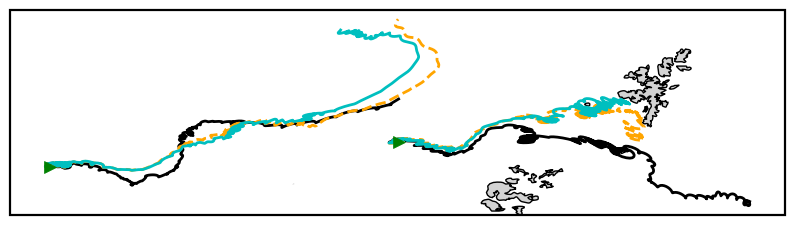

In [46]:
# plot selection of trajectories

year=2023
month=9
coriolis = True
fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cart.feature.LAND, facecolor='lightgrey')

ax.plot(data[year][month][coriolis]['lon_tracer'][3000:3100:50,0::1].values.T,
        data[year][month][coriolis]['lat_tracer'][3000:3100:50,0::1].values.T,
        '-',
        color='black');

ax.plot(data[year][month][coriolis]['lon_MRSM'][3000:3100:50,0::1].values.T,
        data[year][month][coriolis]['lat_MRSM'][3000:3100:50,0::1].values.T,
        '--',
        color='orange');

ax.plot(data[year][month][coriolis]['lon_MR'][3000:3100:50,0::1].values.T,
        data[year][month][coriolis]['lat_MR'][3000:3100:50,0::1].values.T,
        '-',
        color='c');




ax.plot(data[year][month][coriolis]['lon_MRSM'][3000:3100:50,0].values,
        data[year][month][coriolis]['lat_MRSM'][3000:3100:50,0].values,
        '>',
        color='green',
        zorder=20)




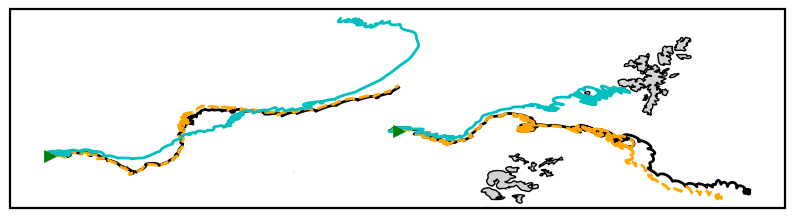

In [38]:
# compare coriolis on / off with tracer

year=2023
month=9
coriolis = True
fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cart.feature.LAND, facecolor='lightgrey')

ax.plot(data[year][month][True]['lon_tracer'][3000:3100:50,0::1].values.T,
        data[year][month][True]['lat_tracer'][3000:3100:50,0::1].values.T,
        '-',
        color='black');

ax.plot(data[year][month][False]['lon_MR'][3000:3100:50,0::1].values.T,
        data[year][month][False]['lat_MR'][3000:3100:50,0::1].values.T,
        '--',
        color='orange');

ax.plot(data[year][month][True]['lon_MR'][3000:3100:50,0::1].values.T,
        data[year][month][True]['lat_MR'][3000:3100:50,0::1].values.T,
        '-',
        color='c');




ax.plot(data[year][month][True]['lon_tracer'][3000:3100:50,0].values,
        data[year][month][True]['lat_tracer'][3000:3100:50,0].values,
        '>',
        color='green',
        zorder=20)


## calculate tidal mean lons and lats
Inertial particles are advected differently by the tides than tracer particles.   
To supress the effect of tidal oscilations we calculate the tidal average   
(averaged over 25h) signal for all the particles.  


In [8]:
# needed functions: 
def calc_tidal_av(coordinates, window):
    cs = coordinates.cumsum(dim='obs',skipna=False)
    mean = (cs-cs.roll(obs=window))/float(window)#(cs[:,window:]-cs[:,:-window])#/float(window)
    return mean

In [9]:
#test
xarray = xr.DataArray([1,2,3,4,5,6,7],dims='x')
xarray_roll = xarray.roll(x=2)
print(xarray)
diff = xarray-xarray_roll
print(diff)

<xarray.DataArray (x: 7)> Size: 56B
array([1, 2, 3, 4, 5, 6, 7])
Dimensions without coordinates: x
<xarray.DataArray (x: 7)> Size: 56B
array([-5, -5,  2,  2,  2,  2,  2])
Dimensions without coordinates: x


In [10]:
# add tidal average lons and lats 
window=25
startnan=np.full((nparticles,25),np.nan)
endnan=np.full((nparticles,80),np.nan)
Tend=720

for starttime in starttimes:
    year = starttime.year
    month = starttime.month

    for particle_type in particle_types:
        lonname = rename_coordinates[particle_type]['lon']
        latname = rename_coordinates[particle_type]['lat']
        timename = rename_coordinates[particle_type]['time']

        da_lon_tidal_av = calc_tidal_av(data[year][month][lonname],window)
        da_lat_tidal_av = calc_tidal_av(data[year][month][latname],window)

        data[year][month] = data[year][month].assign(lon_tidal_av = da_lon_tidal_av)
        data[year][month] = data[year][month].assign(lat_tidal_av = da_lat_tidal_av)
        data[year][month] = data[year][month].rename({'lon_tidal_av':f'{lonname}_tidal_av','lat_tidal_av':f'{latname}_tidal_av'})


 


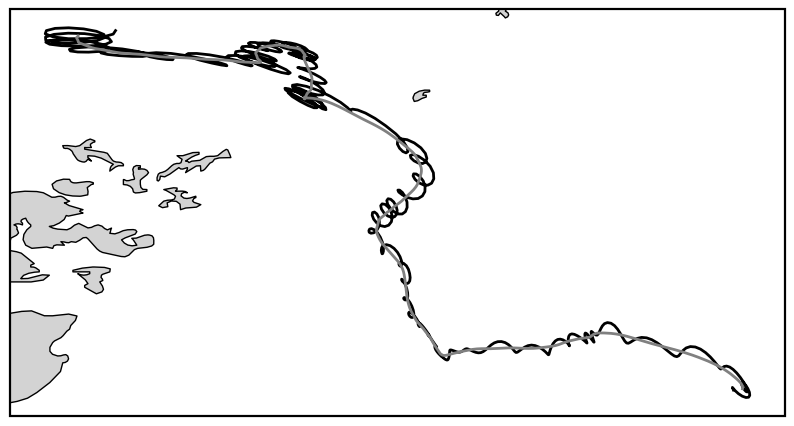

In [11]:
# plot tidal and nontidal trajectory to check that calculation went correct
year=2023
month=9
id_particle=4

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cart.feature.LAND, facecolor='lightgrey')

ax.plot(data[year][month]['lon_tracer'][id_particle].values.T,
        data[year][month]['lat_tracer'][id_particle].values.T,
        '-',
        color='black');

ax.plot(data[year][month]['lon_tracer_tidal_av'][id_particle].values.T,
        data[year][month]['lat_tracer_tidal_av'][id_particle].values.T,
        '-',
        color='grey');


## Along track displacement

In [12]:
# along track distance

tmax = 680

#arrays

traj_lengths = {'tracer':np.array([]),
          'inertial':np.array([]),
          'inertial_SM':np.array([]),
           'tracer_tidal_av':np.array([]),
          'inertial_tidal_av':np.array([]),
          'inertial_SM_tidal_av':np.array([])} 
   
arrays = {'tracer':np.array([]),
          'inertial':np.array([]),
          'inertial_SM':np.array([]),
          'tracer_tidal_av':np.array([]),
          'inertial_tidal_av':np.array([]),
          'inertial_SM_tidal_av':np.array([])}

arrays_diff = {'inertial':np.array([]),
          'inertial_SM':np.array([]),
          'inertial_tidal_av':np.array([]),
          'inertial_SM_tidal_av':np.array([])}

#loop over all months 
i=0
for starttime in starttimes:
    year = starttime.year
    month = starttime.month

    # calculate trajectorly length
    for particle_type in particle_types: 
        lonname = rename_coordinates[particle_type]['lon']
        latname = rename_coordinates[particle_type]['lat']
        timename = rename_coordinates[particle_type]['time']

        traj_lengths[particle_type] = trajectory_length(data[year][month][lonname], data[year][month][latname])
        arrays[particle_type] = np.concatenate((arrays[particle_type], traj_lengths[particle_type][:,tmax][~np.isnan(traj_lengths[particle_type][:,tmax])]))
        if(particle_type != 'tracer'):
            diff_traj_lengths=traj_lengths[particle_type]-traj_lengths['tracer']
            arrays_diff[particle_type] = np.concatenate((arrays_diff[particle_type], diff_traj_lengths[:,tmax][~np.isnan(diff_traj_lengths[:,tmax])]))

    for particle_type in particle_types: 
        lonname = rename_coordinates[particle_type]['lon']+'_tidal_av'
        latname = rename_coordinates[particle_type]['lat']+'_tidal_av'
        timename = rename_coordinates[particle_type]['time']+'_tidal_av'

        traj_lengths[particle_type+'_tidal_av'] = trajectory_length(data[year][month][lonname][:,25:], data[year][month][latname][:,25:])
        arrays[particle_type+'_tidal_av'] = np.concatenate((arrays[particle_type+'_tidal_av'], traj_lengths[particle_type+'_tidal_av'][:,tmax-25][~np.isnan(traj_lengths[particle_type+'_tidal_av'][:,tmax-25])]))
        if(particle_type != 'tracer'):
            diff_traj_lengths=traj_lengths[particle_type+'_tidal_av']-traj_lengths['tracer_tidal_av']
            arrays_diff[particle_type+'_tidal_av'] = np.concatenate((arrays_diff[particle_type+'_tidal_av'], diff_traj_lengths[:,tmax][~np.isnan(diff_traj_lengths[:,tmax])]))



(316437,)
(320525,)
(321056,)


Text(0.5, 0, 'distance (km)')

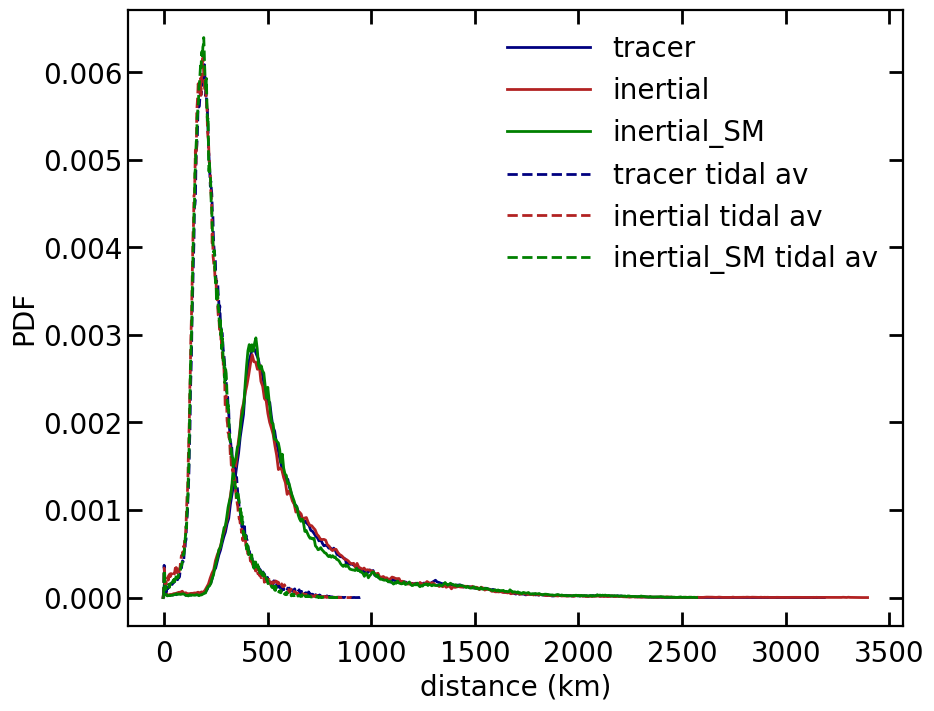

In [13]:
# plot total trajectory lengh pdf
color_particles = {'tracer':'navy','inertial':'firebrick','inertial_SM':'green'}
fig,ax=plt.subplots()
legend=[]
for particle_type in particle_types:
    print(arrays[particle_type].shape)
    bins, pdf = make_PDF(arrays[particle_type],401, norm=True)
    ax.plot(bins,pdf,'-',color=color_particles[particle_type])
    legend.append(particle_type)
    #tidal_av
   


for particle_type in particle_types:
    bins, pdf = make_PDF(arrays[particle_type+'_tidal_av'],401, norm=True)
    ax.plot(bins,pdf,'--',color=color_particles[particle_type])
    legend.append(particle_type+' tidal av')

ax.legend(legend)
ax.set_ylabel("PDF")
ax.set_xlabel("distance (km)")

(320525,)
(321056,)


Text(0.5, 0, 'distance compared to tracer particle (km)')

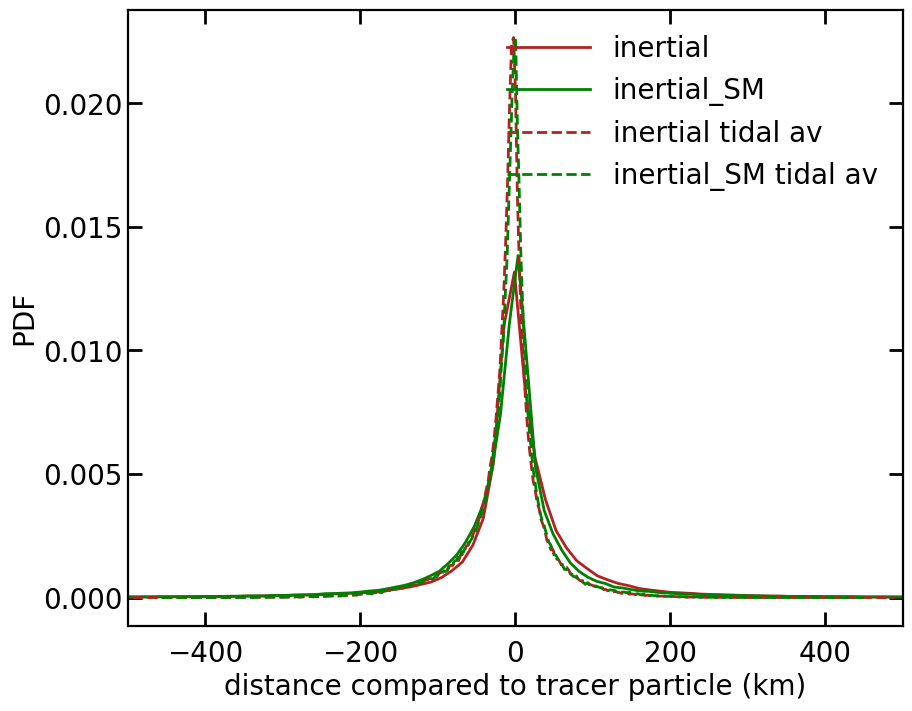

In [14]:
# plot difference trajectory lengh MR particle and tracer particle pdf
color_particles = {'tracer':'navy','inertial':'firebrick','inertial_SM':'green'}
fig,ax=plt.subplots()
legend = []
for particle_type in ['inertial','inertial_SM']:
    print(arrays[particle_type].shape)
    bins, pdf = make_PDF(arrays_diff[particle_type],401, norm=True)

    ax.plot(bins,pdf,'-',color=color_particles[particle_type])
    legend.append(particle_type)

for particle_type in ['inertial','inertial_SM']:
    bins, pdf = make_PDF(arrays_diff[particle_type+'_tidal_av'],401, norm=True)
    ax.plot(bins,pdf,'--',color=color_particles[particle_type])
    legend.append(particle_type + ' tidal av')
ax.legend(legend)

ax.set_xlim(-500,500)
ax.set_ylabel("PDF")
ax.set_xlabel("distance compared to tracer particle (km)")

#### conclusion
If we compare the difference in the along track distance compared to the tracer particle we see that the   
displaced particles have a smaller spread compared to the inertial particles. For the displaced particles  
there is no big difference between the tidal and non-tidal average.   
For the inertial particles there is a clear difference between the tidal average and not averaged signal.   
For the intertial particls the not-averaged distribution is centered around a value bigger than 0. This is   
because the tidal circle of intertial particles is bigger than the tidal cycle of the tracer particles.  
If we average over the tidal we see that the distributuion shifts back to zero. We find that the tidal   
averaraged distribution for the inertial particles is wider (more spread) than the distribution of the  
displaced particles.  

### Relative dispersion

In [16]:
# # EVALULATE IF YOU WANT TO REMOVE DISTANCE CALCULATION
# distname = {'inertial':'dist_inertial_tracer','inertial_SM':'dist_inertial_SM_tracer'}
# for starttime in starttimes:
#     print(starttime)
#     year = starttime.year
#     month = starttime.month
#     for particle_type in ['inertial','inertial_SM']: 
#         data[year][month]=data[year][month].drop_vars(distname[particle_type])
#         data[year][month]=data[year][month].drop_vars(distname[particle_type]+'_tidal_av')

In [ ]:
for particle_type_a, particle_type_b in [['inertial','tracer'],['inertial_SM','tracer'],['inertial_SM','inertial']]: 
    print(particle_type_a)
    print(particle_type_b)

In [19]:
## Relative dispersion of the distance between differen type of particle pairs
i=0

legend=[]
distname = {'inertial':'dist_inertial_tracer','inertial_SM':'dist_inertial_SM_tracer'}
D_MR=np.zeros(800)
D_MRSM=np.zeros(800)
D_random=np.zeros(800)
D_MR_per_month=[]
D_MRSM_per_month=[]
D_random_per_month=[]

#tidal average
D_MR_tidal_av=np.zeros(800)
D_MRSM_tidal_av=np.zeros(800)
D_random_tidal_av=np.zeros(800)
D_MR_per_month_tidal_av=[]
D_MRSM_per_month_tidal_av=[]
D_random_per_month_tidal_av=[]

# D_MR_random=np.zeros(800)
for starttime in starttimes:
    print(starttime)
    year = starttime.year
    month = starttime.month
    for particle_type_a, particle_type_b in [['inertial','tracer'],['inertial_SM','tracer'],['inertial_SM','inertial']]: 
        

        lonname_a = rename_coordinates[particle_type_a]['lon']
        latname_a = rename_coordinates[particle_type_a]['lat']
        lonname_b = rename_coordinates[particle_type_b]['lon']
        latname_b = rename_coordinates[particle_type_b]['lat']

        dist = Haversine(data[year][month][lonname_b],data[year][month][latname_b],
                               data[year][month][lonname_a], data[year][month][latname_a])

        da_dist = xr.DataArray(dist, dims=['trajectory','obs'])
        data[year][month]=data[year][month].assign(dist = da_dist)
        data[year][month]=data[year][month].rename({'dist':'dist_'+particle_type_a+'_'+particle_type_b})

        #tidal av
        lonname_a = rename_coordinates[particle_type_a]['lon']+'_tidal_av'
        latname_a = rename_coordinates[particle_type_a]['lat']+'_tidal_av'
        lonname_b = rename_coordinates[particle_type_b]['lon']+'_tidal_av'
        latname_b = rename_coordinates[particle_type_b]['lat']+'_tidal_av'

        dist_tidal_av = Haversine(data[year][month][lonname_b],data[year][month][latname_b],
                               data[year][month][lonname_a], data[year][month][latname_a])

        da_dist_tidal_av = xr.DataArray(dist_tidal_av, dims=['trajectory','obs'])
        data[year][month]=data[year][month].assign(dist_tidal_av = da_dist_tidal_av)
        data[year][month]=data[year][month].rename({'dist_tidal_av':'dist_tidal_av_'+particle_type_a+'_'+particle_type_b})

2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00


2023-09-01 00:00:00
76259
0.0
539.37866
2023-10-01 00:00:00
77426
0.0
453.06415
2023-11-01 00:00:00
75115
0.0
495.73282
2023-12-01 00:00:00
77925
0.0
487.7625


Text(0, 0.5, 'PDF')

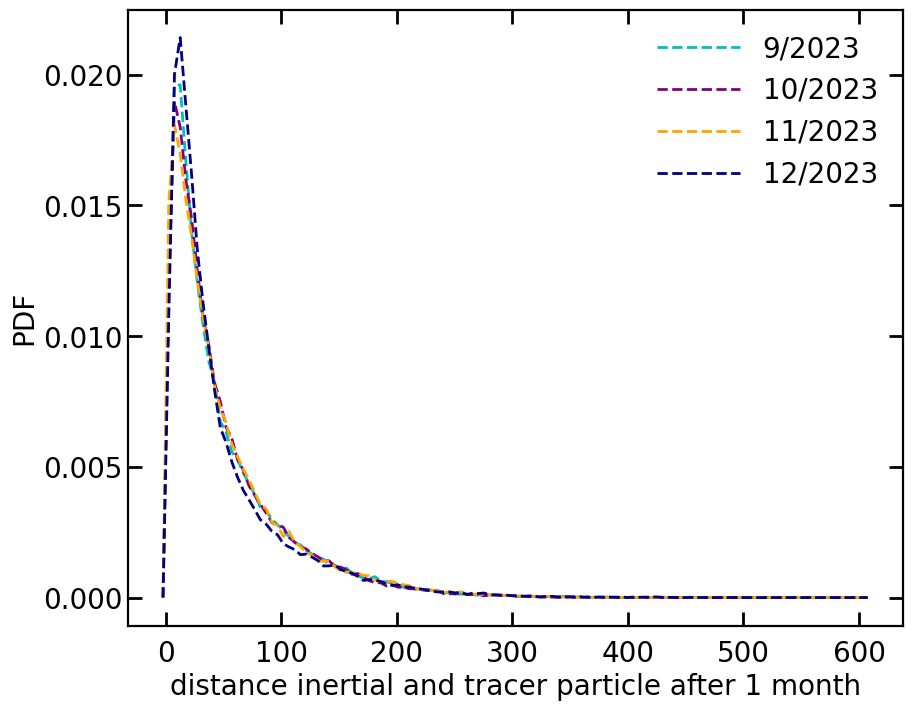

In [33]:
# plot distribution final distance between particles
tfinal = 719
fig,ax=plt.subplots()
i=0
legend=[]
for starttime in starttimes:
    print(starttime)
    year = starttime.year
    month = starttime.month
    array = data[year][month].dist_tidal_av_inertial_tracer[:,tfinal].values
    array=array[~np.isnan(array)]
    print(array.size)
    print(array.min())
    print(array.max())
    bins,pdf = make_PDF(array,121,norm=True,min=0,max=600)
    
    ax.plot(bins, pdf, '--', color=colorlist[i])

    
    legend.append(f'{month:0d}/{year:04d}')
    i+=1
ax.legend(legend)
ax.set_xlabel('distance inertial and tracer particle after 1 month')
ax.set_ylabel('PDF')




2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00


Text(0, 0.5, 'distance between inertial and tracer particle')

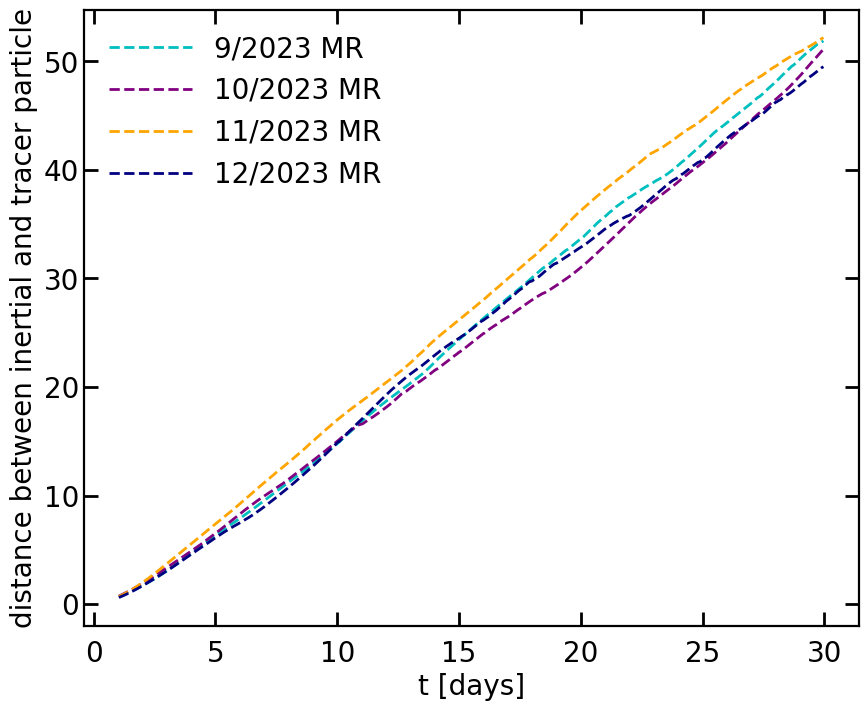

In [32]:
# plot distribution final distance between particles
# slow manifold finds bigger seperation distance (as expected because more oscillations)
tfinal = 719
fig,ax=plt.subplots()
i=0
legend=[]
for starttime in starttimes:
    print(starttime)
    year = starttime.year
    month = starttime.month
    values=data[year][month].dist_tidal_av_inertial_tracer.mean(dim='trajectory',skipna=True).values
    tlist=np.arange(0,values.size,1)/24
    
    ax.plot(tlist, values, '--', color=colorlist[i])

    
    legend.append(f'{month:0d}/{year:04d} MR')

    # values_SM=data[year][month].dist_tidal_av_inertial_SM_tracer.mean(dim='trajectory',skipna=True).values
    # tlist=np.arange(0,values_SM.size,1)
    
    # ax.plot(tlist, values_SM, '-', color=colorlist[i])

    
    # legend.append(f'{month:0d}/{year:04d} MR SM')
    i+=1
ax.legend(legend)
ax.set_xlabel('t [days]')
ax.set_ylabel('distance between inertial and tracer particle')

In [ ]:
# calculate relative dispersion

fig,ax=plt.subplots()
tend =  720
tstart = 1
tlist_tidal_av=np.arange(0.5*window, tend-0.5*window,1)
tlist=np.arange(0,800,1)
legend=[]
colors=['firebrick','green','navy']
i=0
for particle_type in ['inertial_tracer','inertial_SM_tracer']:
    Dtotal = np.zeros(800)
    Dtotal_tidal_av = np.zeros(800)
    for starttime in starttimes:
        year = starttime.year
        month = starttime.month

        d = (data[year][month]['dist_'+particle_type]**2).mean(dim='trajectory',skipna=True).values
        Dtotal += d 

        d_tidal_av = (data[year][month]['dist_tidal_av_'+particle_type]**2).mean(dim='trajectory',skipna=True).values
        Dtotal_tidal_av += d_tidal_av 
    legend.append(particle_type)
    legend.append(particle_type+' tidal_av')

    Dtotal/=starttimes.size
    Dtotal_tidal_av/=starttimes.size
    ax.plot(tlist[tstart:tend],Dtotal[tstart:tend],color=colors[i])
    ax.plot(tlist_tidal_av,Dtotal_tidal_av[window:tend],'--',color=colors[i])
    i+=1
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Relative Dispersion [m$^2$]')
ax.set_xlabel('time [hours]')
ax.legend(legend)


## scatter/trajectory plots

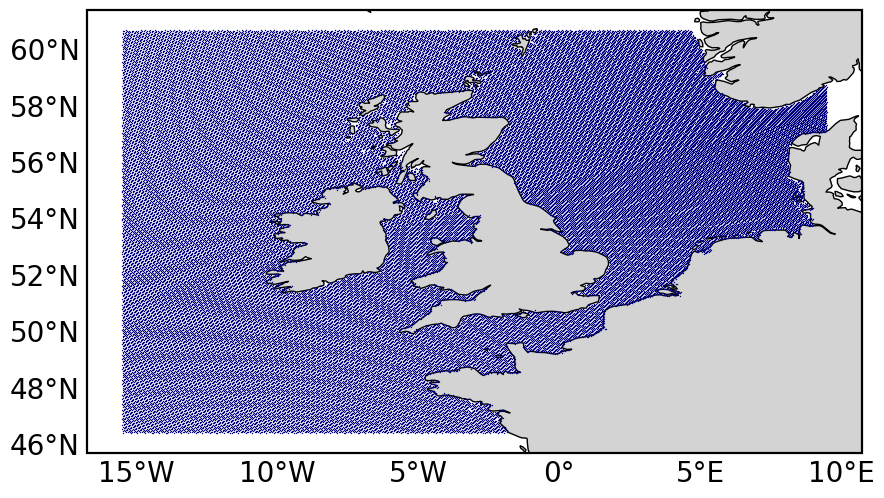

In [34]:
# starting positions plot
i=0
year = starttime.year
month = starttime.month
fig,ax=plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})

ax.plot(data[year][month].lon_tracer[:,0].values, data[year][month].lat_tracer[:,0].values,'.',color='navy',markersize=1)
ax.coastlines()
ax.add_feature(cart.feature.LAND,facecolor='lightgrey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
            linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}


2023-09-01 00:00:00


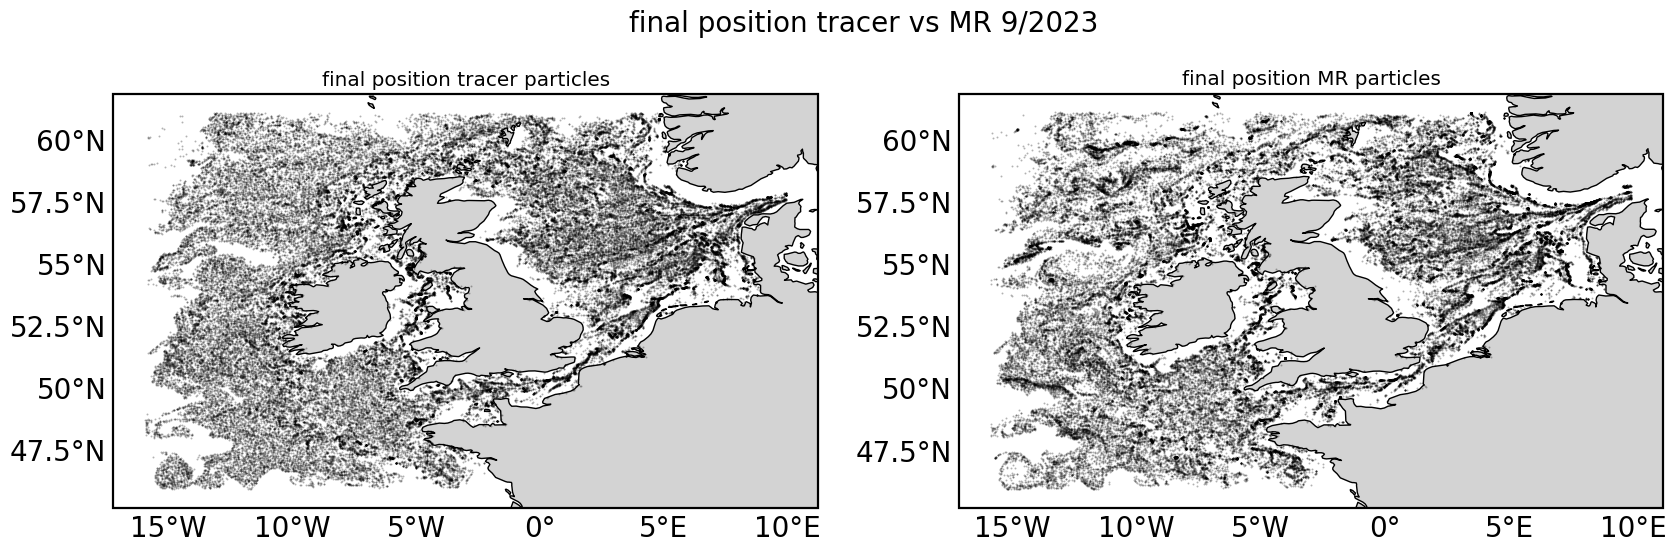

In [62]:
# plot location particles at tstep


i=0
tstep=719

for starttime in starttimes:
    fig,axs=plt.subplots(1,2,figsize=(20,6),
                     subplot_kw={'projection':ccrs.PlateCarree()})
    print(starttime)
    year = starttime.year
    month = starttime.month
    

    # axs[0].plot(data[year][month].lon_tracer.ffill(dim='obs')[:,-1], data[year][month].lat_tracer.ffill(dim='obs')[:,-1],'.',alpha=0.5,color='navy',markersize=2)
    # axs[1].plot(data[year][month].lon_MR.ffill(dim='obs')[:,-1], data[year][month].lat_MR.ffill(dim='obs')[:,-1],'.',alpha=0.5,color='firebrick',markersize=2)
    
    # axs[0].plot(data[year][month].lon_MR_tidal_av[:,tstep], data[year][month].lat_MR_tidal_av[:,tstep],'.',alpha=0.2,color='orange',markersize=8,zorder=2)
 
    
    axs[0].plot(data[year][month][True].lon_tracer[:,tstep], data[year][month][True].lat_tracer[:,tstep],'.',alpha=0.2,color='black',markersize=2)
    axs[1].plot(data[year][month][True].lon_MR[:,tstep], data[year][month][True].lat_MR[:,tstep],'.',alpha=0.2,color='black',markersize=2)

       
    # axs[1].plot(data[year][month][True].lon_MR[:,tstep], data[year][month][True].lat_MR[:,tstep],'.',alpha=0.4,color='orange',markersize=2)
    # axs[1].plot(data[year][month][True].lon_tracer[:,tstep], data[year][month][True].lat_tracer[:,tstep],'.',alpha=0.4,color='black',markersize=2)
    # axs[0].plot(data[year][month][True].lon_MRSM[:,tstep], data[year][month][True].lat_MRSM[:,tstep],'.',alpha=0.5,color='orange',markersize=2,zorder=20)
    # axs[0].plot(data[year][month].lon_tracer_tidal_av[:,tstep], data[year][month].lat_tracer_tidal_av[:,tstep],'.',alpha=0.5,color='c',markersize=2,zorder=20)

    # axs[1].plot(data[year][month].lon_tracer_tidal_av[:,tstep], data[year][month].lat_tracer_tidal_av[:,tstep],'.',alpha=0.5,color='c',markersize=2)
    
    # axs[1].plot(data[year][month][True].lon_MR[:,tstep], data[year][month][True].lat_MR[:,tstep],'.',alpha=0.5,color='k',markersize=2,zorder=20)
    



    for ax in axs:
        ax.coastlines()
        ax.add_feature(cart.feature.LAND,facecolor='lightgrey')
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 20}
        gl.ylabel_style =  {'size': 20}

    axs[0].set_title(f'final position tracer particles')
    axs[1].set_title(f'final position MR particles')
    # axs[0].set_title(f'MR on top of tracer')
    # axs[1].set_title(f'tracer on top of MR')
    fig.suptitle(f'final position tracer vs MR {month}/{year}', fontsize=20)
    # axs[0].set_xlim(-4,10)
    # axs[0].set_ylim(50.5,61.5)
    # axs[1].set_xlim(-4,)
    # axs[1].set_ylim(50.5,61.5)


In [41]:
# make movie pariicles

# plot location particles at tstep
starttime = starttimes[0]
year = starttime.year
month = starttime.month
coriolis = True
for tindex in range(0,720,1):
    fig,ax=plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})

    ax.plot(data[year][month][coriolis].lon_MR[:,tindex], data[year][month][coriolis].lat_MR[:,tindex],'.',alpha=0.3,color='c',markersize=3)
 


    ax.coastlines()
    ax.add_feature(cart.feature.LAND,facecolor='lightgrey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}
    ax.set_xlim(-16,10)
    ax.set_ylim(45.5,61.5)

    date=starttime+timedelta(seconds=data[year][month][coriolis].time_tracer[0].values[tindex])
    ax.set_title(date)
    fig.savefig(f'../figures/lagrangian_field/frames/september/inertial_cor_{coriolis}_{tindex:04d}.png')
    plt.close(fig)

     # to make movie
    # ffmpeg -framerate 20 -i tracer_%04d.png  -vcodec libx264 -pix_fmt yuv420p -r 10 tracer.mp4
     # ffmpeg -framerate 20 -i inertial_SM_cor_True_%04d.png  -vcodec libx264 -pix_fmt yuv420p -r 10 inertial_SM_cor_True.mp4


    # ffmpeg -framerate 20 -i inertial_cor_True_%04d.png  -vcodec libx264 -pix_fmt yuv420p -r 10 inertial_cor_True.mp4

        # ffmpeg -framerate 20 -i inertial_SM_%04d.png  -vcodec libx264 -pix_fmt yuv420p -r 10 inertial_SM.mp4




In [ ]:
# make movie particles tidal averaged

# plot location particles at tstep
starttime = starttimes[0]
year = starttime.year
month = starttime.month
for tindex in range(0,720-25,1):
    fig,ax=plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    tstep = tindex+25
    ax.plot(data[year][month].lon_tracer_tidal_av[:,tstep], data[year][month].lat_tracer_tidal_av[:,tstep],'.',alpha=0.3,color='navy',markersize=3)
 


    ax.coastlines()
    ax.add_feature(cart.feature.LAND,facecolor='lightgrey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}
    ax.set_xlim(-16,10)
    ax.set_ylim(45.5,61.5)

    date=starttime+timedelta(seconds=data[year][month].time_tracer[0].values[tindex+12]+30*60)
    ax.set_title(date)
    fig.savefig(f'../figures/lagrangian_field/frames/september/tracer_tidal_av_{tindex:04d}.png')
    plt.close(fig)

     # to make movie
    # ffmpeg -framerate 20 -i tracer_tidal_av_%04d.png  -vcodec libx264 -pix_fmt yuv420p -r 10 tracer_tidal_av.mp4

    # ffmpeg -framerate 20 -i inertial_tidal_av_%04d.png  -vcodec libx264 -pix_fmt yuv420p -r 10 inertial_tidal_av.mp4




In [ ]:
cmax=50

fig,axs=plt.subplots(1,2,figsize=(30,8),
                     subplot_kw={'projection':ccrs.PlateCarree()})
starttime=starttimes[3]
year = starttime.year
month = starttime.month

# make dataset where only values where difference bigger than cmax are saved
ds_cmax = data[year][month].where(data[year][month].dist_inertial_SM_inertial > cmax)

first_lon = ds_cmax.lon_tracer.bfill(dim='obs')[:,0]
first_lat = ds_cmax.lat_tracer.bfill(dim='obs')[:,0]

select=~np.isnan(first_lon.values)  
index_select = np.arange(0,nparticles,1)[select]
ds_cmax_all=data[year][month].isel(trajectory=index_select)
start_lon = ds_cmax_all.lon_tracer[:,0]
start_lat = ds_cmax_all.lat_tracer[:,0]
final_lon = ds_cmax_all.lon_MR.ffill(dim='obs')[:,-1]
final_lat = ds_cmax_all.lat_MR.ffill(dim='obs')[:,-1]
    
#use bfill to plot first nonnan value
axs[1].plot(final_lon, final_lat,'.',color='firebrick',markersize=3)
axs[0].plot(start_lon,start_lat,'.',color='firebrick',markersize=3)

#select=~np.isnan(first_lon.values)  
select=np.isnan(first_lon.values)  
index_select = np.arange(0,nparticles,1)[select]

ds_cmin = data[year][month].isel(trajectory=index_select)

start_lon = ds_cmin.lon_tracer[:,0]
start_lat = ds_cmin.lat_tracer[:,0]
final_lon = ds_cmin.lon_MR.ffill(dim='obs')[:,-1]
final_lat = ds_cmin.lat_MR.ffill(dim='obs')[:,-1]
axs[1].plot(final_lon, final_lat,'.',color='navy',markersize=3)


axs[0].plot(start_lon,start_lat,'.',color='navy',markersize=3)
ntotal_cmax=ds_cmax.lon_tracer.bfill(dim='obs')[:,0].dropna('trajectory').shape[0]
ntotal_cmin=ds_cmin.lon_tracer.bfill(dim='obs')[:,0].dropna('trajectory').shape[0]

for ax in axs:
    ax.coastlines()
    ax.add_feature(cart.feature.LAND,facecolor='lightgrey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}

axs[0].set_title(f'starting position ')
axs[1].set_title(f'final position')
ax.legend([f'distance > {cmax} km',f'distance < {cmax} km'])
fig.suptitle(f'tracer vs full MR {month}/{year}', fontsize=20)

print(f'fraction dist > {cmax} km = {(nparticles - index_select.size) / nparticles}')

# back to the artificial lines? 

In [ ]:
# scatter final position MR particle colored according to separation disance MR particle and tracer particle

# cmax = 10 #1 # 0.1 # km
i=0

for starttime in starttimes:
    fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    print(starttime)
    year = starttime.year
    month = starttime.month
    
    # final (non-nan) value of trajectory
    final_lon = data[year][month].lon_MR.ffill(dim='obs')[:,-1]
    final_lat = data[year][month].lat_MR.ffill(dim='obs')[:,-1]
    final_separation = data[year][month].dist_inertial_tracer.ffill(dim='obs')[:,-1]
    #use bfill to plot first nonnan value
    sc=ax.scatter(final_lon, final_lat,s=1,c=final_separation,alpha=0.5,cmap='viridis_r',vmin=0,vmax=250)
    cxbar=fig.colorbar(sc,fraction=0.03)
    cxbar.set_label(label='final distance tracer and intertial particle',fontsize=15)

    i+=1
    ax.coastlines()
    ax.add_feature(cart.feature.LAND,facecolor='lightgrey')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}


    # ax.set_xlim(-3,10)
    # ax.set_ylim(50,61.5)
    ax.set_title(starttime )



In [ ]:
# scatter final position particle colored according to separation disance MR particle and tracer particle

# cmax = 10 #1 # 0.1 # km
i=0

for starttime in starttimes:
    fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    print(starttime)
    year = starttime.year
    month = starttime.month
    
    # final (non-nan) value of trajectory
    start_lon = data[year][month].lon_tracer[:,0]
    start_lat = data[year][month].lat_tracer[:,0]
    final_separation = data[year][month].dist_inertial_tracer.ffill(dim='obs')[:,-1]
    #use bfill to plot first nonnan value
 
    sc=ax.scatter(start_lon, start_lat,s=0.5,c=final_separation,alpha=1,cmap='viridis_r',vmin=0,vmax=100)
    cxbar=fig.colorbar(sc,fraction=0.03)
    cxbar.set_label(label='final distance inertial and tracer particle',fontsize=15)

    

    i+=1
    ax.coastlines()
    ax.add_feature(cart.feature.LAND,facecolor='lightgrey')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}


    # ax.set_xlim(-3,10)
    # ax.set_ylim(50,61.5)
    ax.set_title(starttime)



# PDF and CDF separation distance

In [ ]:
#pdf and cdf 
fig,ax = plt.subplots()
i = 0
cmax =10

ax2=ax.twinx()
markers = ['-','--']
for particle_type in ['tidal_av_inertial_tracer','tidal_av_inertial_SM_tracer']:
    array=[]
    starttime=starttimes[0]
    year = starttime.year
    month = starttime.month
    array = data[year][month]['dist_'+particle_type].values.flatten()
    array = array[~np.isnan(array)]

    for starttime in starttimes[1:]:
        year = starttime.year
        month = starttime.month
    
        
        # array=da.max(dim='obs').values.flatten()
        arr = data[year][month]['dist_'+particle_type].values.flatten()
        arr = arr[~np.isnan(arr)]
        array = np.concatenate((array,arr))
  

    

    bins,pdf=make_PDF(array,nbins = 2000, norm = True)
    dx=bins[1]-bins[0]
    mean_separation = np.sum(bins*pdf*dx)
    var_separation = np.sum(dx*pdf*(bins-mean_separation)**2)
    std_separation = np.sqrt(var_separation)
    skewness_separation = np.sum(dx*pdf*((bins-mean_separation)/std_separation)**3)
    print(f'mean = {mean_separation}')
    print(f'std = {std_separation}')
    print(f'skewness = {skewness_separation}')

    ax.plot(bins,pdf*dx,markers[i],color='navy',markersize=5)


# ax.set_ylim(-0.05,1.05)

    cdf = np.cumsum(pdf*dx)
    cdfMR = cdf
    
    ax2.plot(bins,cdf,markers[i],color='firebrick',markersize=5)
 

    i+=1

ax.yaxis.label.set_color('navy')
ax.tick_params(axis='y', colors='navy')
ax.set_xlabel('separation distance tracer and MR particle [km]')
ax.set_ylabel('PDF',color='navy')
ax.spines['left'].set_color('navy')
ax.set_xlim(-1,150)

ax2.spines['right'].set_color('firebrick')
ax2.spines['left'].set_color('navy')
ax2.yaxis.label.set_color('firebrick')
ax2.tick_params(axis='y', colors='firebrick')
ax2.set_ylabel('CDF',color='firebrick')
ax2.set_ylim(-0.05,1.05)


In [ ]:
fig,ax=plt.subplots()
dbin=bins[1]-bins[0]
ax.plot(bins+0.5*dbin,cdfrandom,'-o',color='navy',markersize=5)
ax.plot(bins+0.5*dbin,cdfMR,'--s',color='firebrick',markersize=5)
ax.set_xlabel('seperation distance [km]')
ax.set_ylabel('CDF')
ax.set_ylim(-0.05,1.05)
# ax.set_xscale('log')
ax.axhline(0.8,color='black',zorder=-20)
ax.axvline(1.4,color='navy',zorder=-20)
ax.axvline(5.9,color='firebrick',zorder=-20)
ax.text(1.6,0.3,'1.4 km',color='navy',fontsize=13)
ax.text(6.2,0.3,'5.9 km',color='firebrick',fontsize=13)
ax.set_xlim(-1,50)
ax.legend(['tracer vs dispaced','tracer vs inertial'])

# Density maps
options: 
- 2D square binning - lagrangian diag: https://github.com/OceanParcels/Lagrangian_diags/blob/main/Diagnostics/2DHistogram_method01.ipynb
- 2D binning hexagonal - code claudio: https://github.com/OceanParcels/NEMO_Ensemble_Lagrangian_Analysis/blob/master/functions/hexbin_functions.py 
- gaussian kernel density estimation (GKDE) - lagrangian diags: https://github.com/OceanParcels/Lagrangian_diags/blob/main/Diagnostics/GKDE_method01.ipynb

As I did all simulations on a hexagonal release grid I will also use the hexagonal binning (stolen from Claudio)


## hexagonal binning



In [36]:
# import needed packages
from importlib import reload
import hexbin_functions as hexfunc
import h3
from shapely.geometry import shape, Point


hexfunc = reload(hexfunc)
# test version, it should be version 4
h3.__version__

'4.1.0b3'

(40.0, 70.0)

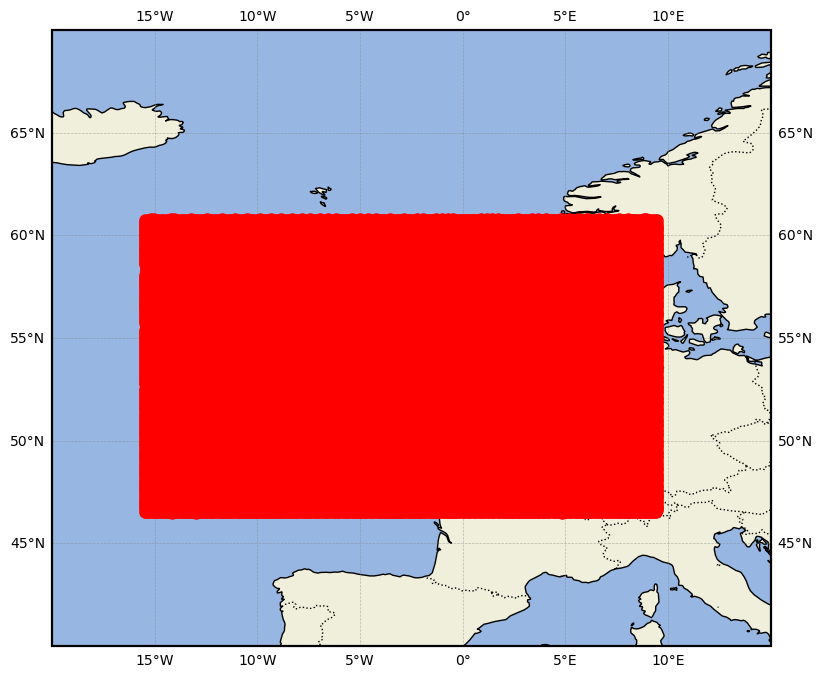

In [38]:
# set region on which we project density map

hex_res = 6
sim_domain = { 
    "type":"Polygon",
    "coordinates": [
   [[9.977004051208496-0.5,61.28188705444336-0.5],
     [-15.996014595031738+0.5,61.28188705444336-0.5],
     [-15.996014595031738+0.5,46.00364303588867+0.5],
     [9.977004051208496-0.5,46.00364303588867+0.5],
     [9.977004051208496-0.5,61.28188705444336-0.5]]
     ]}
hexagons = h3.polygon_to_cells(h3.geo_to_h3shape(sim_domain), hex_res)
hexbin_grid = hexfunc.hexGrid(hexagons, h3_res=hex_res)
hexbin_grid.process_hexagons()

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=cart.crs.PlateCarree())
ax.add_feature(cart.feature.LAND)
ax.add_feature(cart.feature.OCEAN)
ax.add_feature(cart.feature.COASTLINE)
ax.add_feature(cart.feature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.5)
ax.add_geometries([shape(sim_domain)], cart.crs.PlateCarree(), facecolor='green', edgecolor='black', alpha=0.5)


# ax.scatter(lons[:,0],lats[:,0],color='k')
ax.scatter( hexbin_grid.centroid_lons, hexbin_grid.centroid_lats,color='red',zorder=200)

ax.set_xlim(-20,15)
ax.set_ylim(40,70)

# check lon lats 

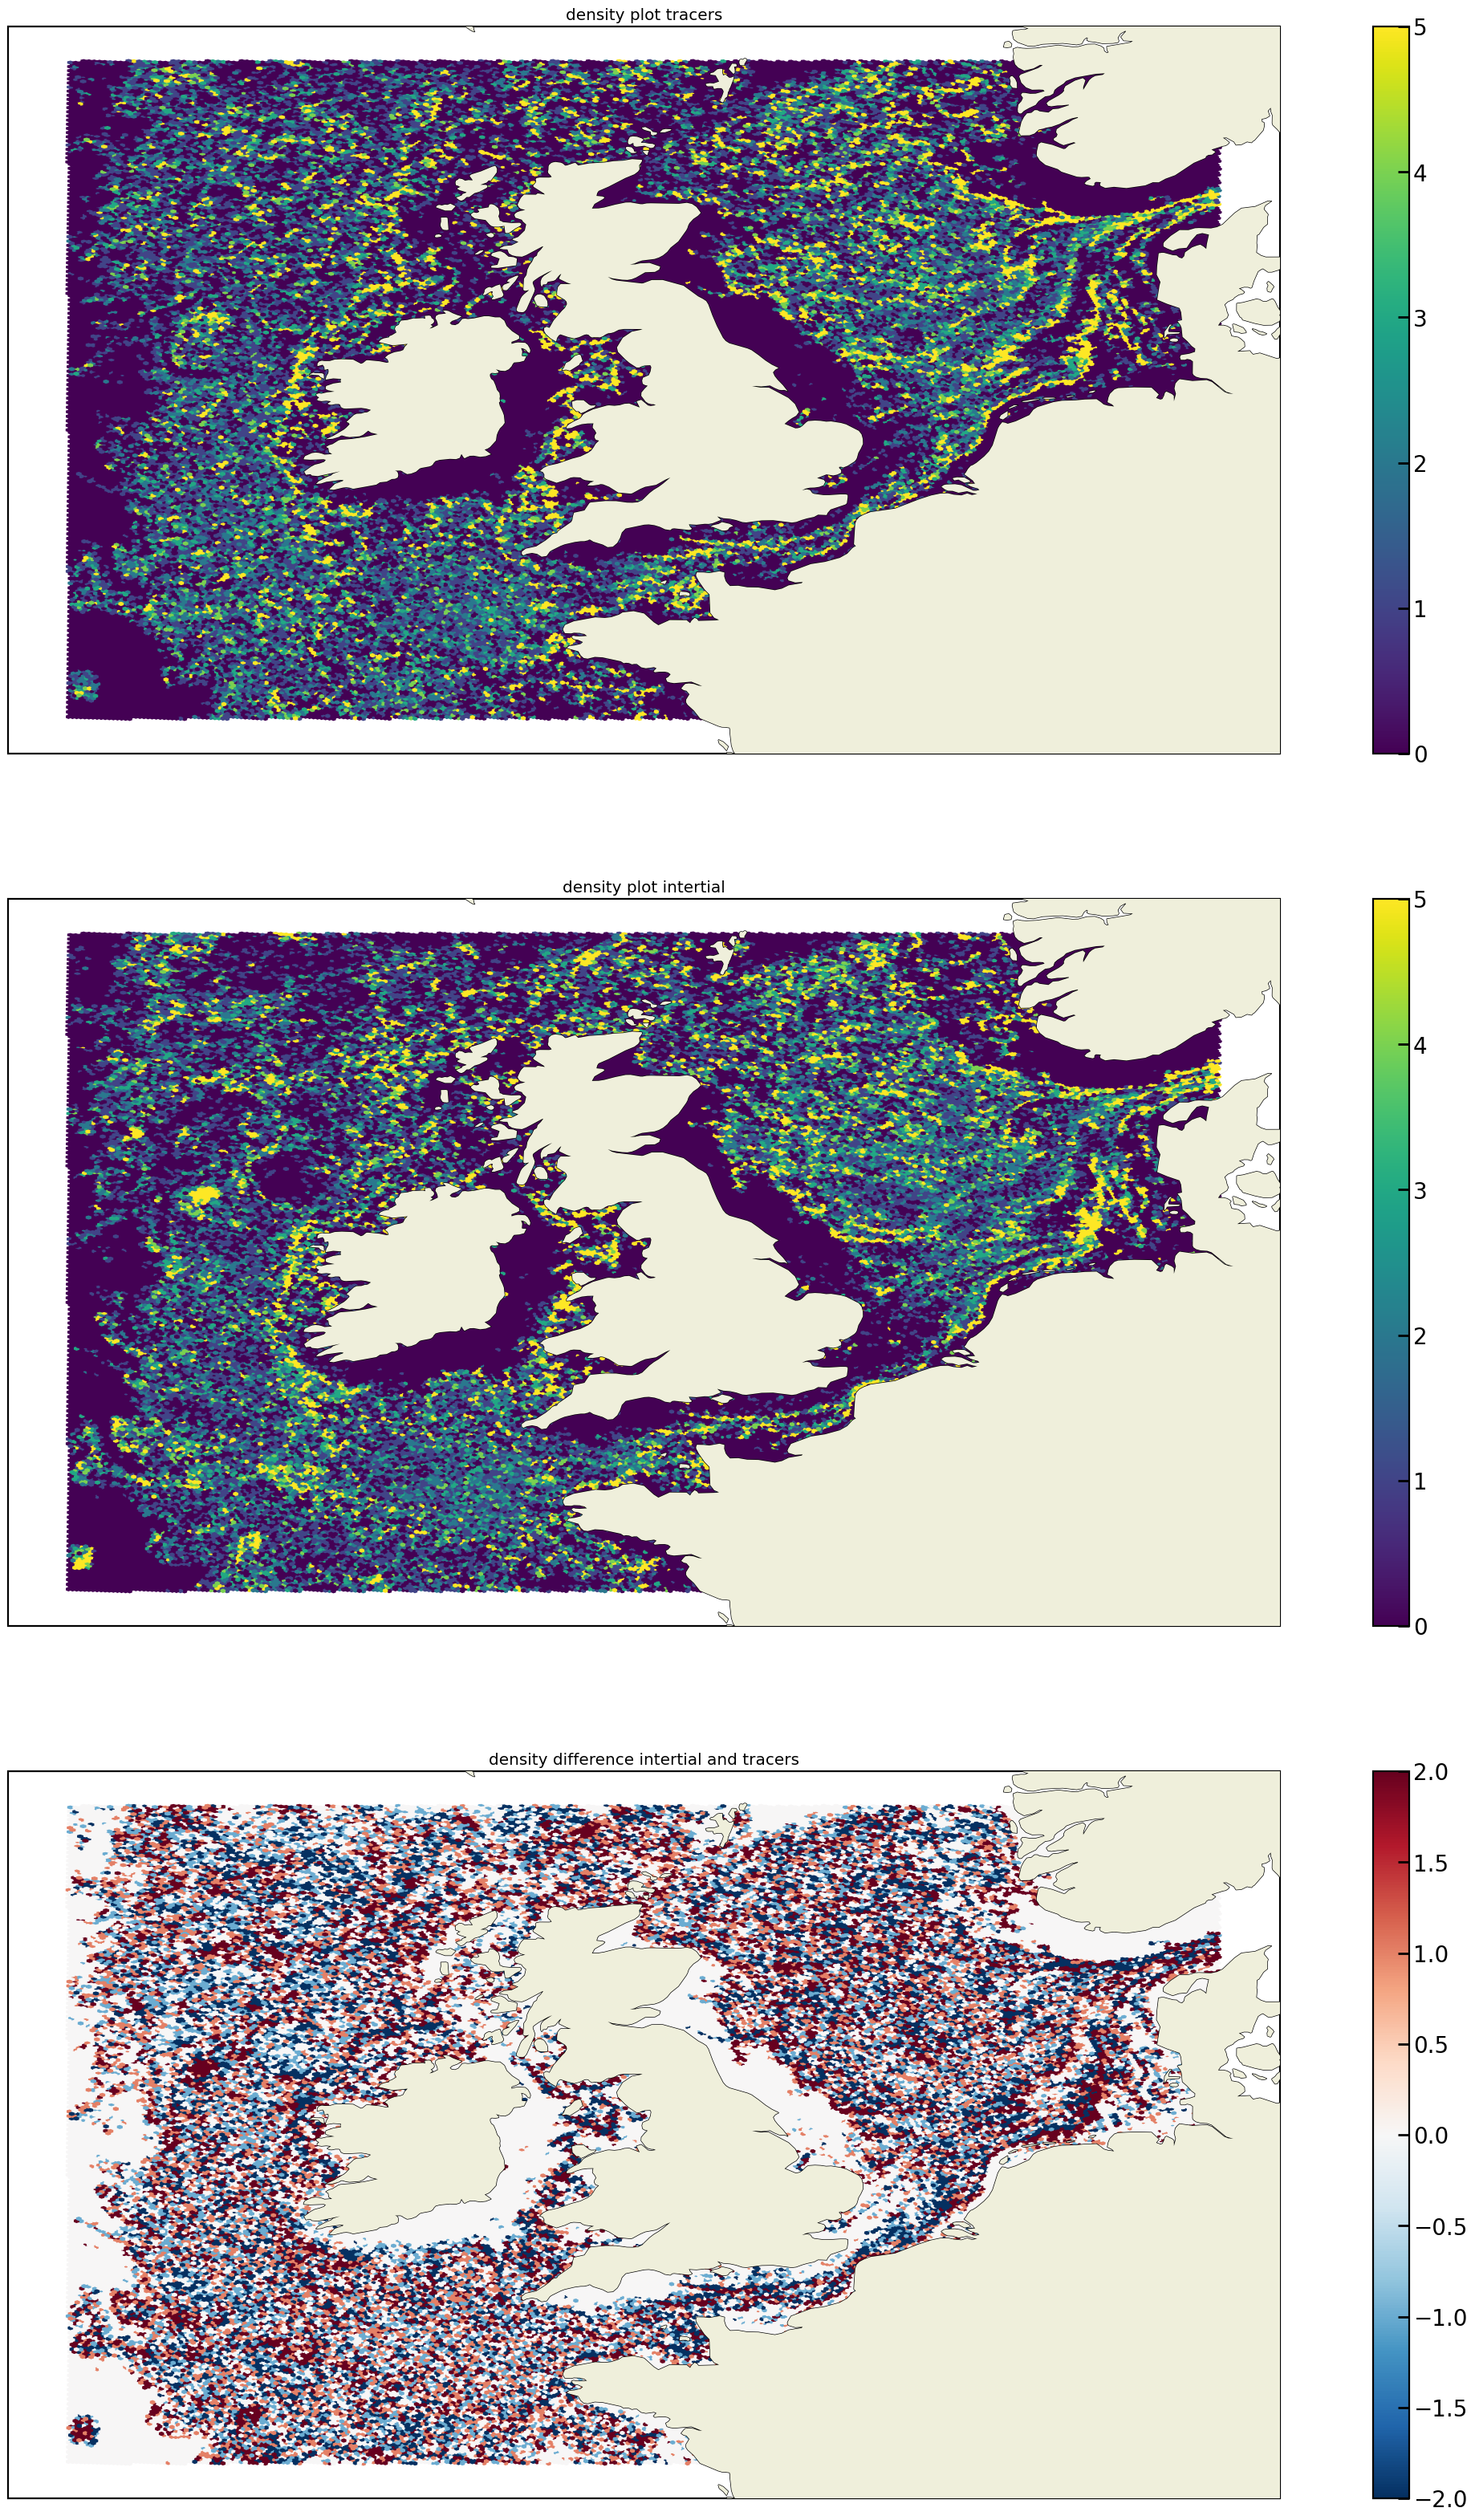

In [39]:
# plot density at end of month

starttime = starttimes[3]
year = starttime.year
month = starttime.month

t=719
probability_set_tracer = np.asarray(hexbin_grid.count_2d(data[year][month].lon_tracer_tidal_av[:, t].values,data[year][month].lat_tracer_tidal_av[:, t].values, normalize=False),dtype='int')
probability_set_inertial = np.asarray(hexbin_grid.count_2d(data[year][month].lon_MR_tidal_av[:, t].values,data[year][month].lat_MR_tidal_av[:, t].values, normalize=False),dtype='int')
probability_set_0 = np.asarray(hexbin_grid.count_2d(data[year][month].lon_tracer[:, 0].values,data[year][month].lat_tracer[:, 0].values, normalize=False),dtype='int')

diff =probability_set_inertial-probability_set_tracer

fig,axs= plt.subplots(
                3, 1,figsize=(30,40), subplot_kw={"projection": cart.crs.PlateCarree()}
            )
for ax in axs:
    ax.add_feature(cart.feature.COASTLINE)
    ax.add_feature(cart.feature.LAND, zorder=20)
# fig.colorbar()
power=6-hex_res
norm=6.**power

sm0 = hexbin_grid.pcolorhex((probability_set_tracer)/norm,
                            minnorm=0, maxnorm = 5,
                            ax=axs[0],cmap='viridis',
                            negative=False)
cbar0 = fig.colorbar(sm0, ax = axs[0])
axs[0].set_title('density plot tracers')

sm1 = hexbin_grid.pcolorhex((probability_set_inertial)/norm,
                            minnorm=0, maxnorm = 5,
                            ax=axs[1],cmap='viridis',
                            negative=False)
cbar1 = fig.colorbar(sm1, ax = axs[1])
axs[1].set_title('density plot intertial')

sm2 = hexbin_grid.pcolorhex((diff)/norm,
                            minnorm=-2, maxnorm = 2,
                            ax=axs[2],cmap='RdBu_r',
                            negative=True)
axs[2].set_title('density difference intertial and tracers')

cbar2 = fig.colorbar(sm2, ax = axs[2])



In [ ]:
fig,ax=plt.subplots()
bin,pdf=make_PDF(probability_set_0, 50,norm=True)
ax.plot(bin,pdf)
meanbin = np.mean(probability_set_0[probability_set_0>0])
meanbin_tracer_end = np.sum(probability_set_tracer)/probability_set_0[probability_set_0>0].size
meanbin_inertia_end = np.sum(probability_set_inertial)/probability_set_0[probability_set_0>0].size
print(meanbin)


In [ ]:
fig,ax=plt.subplots()



bins,pdf_tracer = make_PDF((probability_set_tracer)[probability_set_0>0],126, norm=True,min=0,max=1000)
cdf_tracer = np.cumsum(pdf_tracer*(bins[1]-bins[0]))
ax.plot(bins,pdf_tracer,'-',color='navy')
ax2=ax.twinx()
ax2.plot(bins,cdf_tracer,'--',color='navy')
bins,pdf_MR = make_PDF((probability_set_inertial)[probability_set_0>0],126, norm=True,min=0,max=1000)
cdf_MR= np.cumsum(pdf_MR*(bins[1]-bins[0]))
ax.plot(bins,pdf_MR,'-',color='firebrick')
ax2.plot(bins,cdf_MR,'--',color='firebrick')
# ax.set_yscale('log')
# ax2.set_xlim(-1,100)
ax.axvline(0,color='grey')

In [ ]:
(252+18)/2

In [ ]:
fig,ax=plt.subplots()
ax.plot(bins/12,pdf_MR-pdf_tracer,'-s',color='purple')
ax.axvline(1,color='grey',zorder=-5)
ax.set_xlim(-0.2,10)
ax.axhline(0,color='k',zorder=-20)
ax.set_xlabel('particle density')
ax.set_ylabel('PDF inertial - PDF tracer')

In [ ]:
starttime = starttimes[0]
year = starttime.year
month = starttime.month
probability_set_0 = np.asarray(hexbin_grid.count_2d(data[year][month].lon_tracer[:, 0].values,data[year][month].lat_tracer[:, 0].values, normalize=False),dtype='int')
fig,ax=plt.subplots()
fig2,ax2=plt.subplots()
i=0
legend=[]
for starttime in starttimes:
    year = starttime.year
    month = starttime.month
    probability_set_tracer = np.asarray(hexbin_grid.count_2d(data[year][month].lon_tracer_tidal_av[:, t].values,data[year][month].lat_tracer_tidal_av[:, t].values, normalize=False),dtype='int')
    probability_set_inertial = np.asarray(hexbin_grid.count_2d(data[year][month].lon_MR_tidal_av[:, t].values,data[year][month].lat_MR_tidal_av[:, t].values, normalize=False),dtype='int')
    array_tracer =(probability_set_tracer)[probability_set_0>0]
    array_tracer=array_tracer[~np.isnan(array_tracer)]
    array_MR =(probability_set_inertial)[probability_set_0>0]
    array_MR=array_MR[~np.isnan(array_MR)]
    max1=array_MR.max()
    max2=array_tracer.max()
    bins,pdf_tracer = make_PDF(array_tracer,351, norm=True,min=0,max=1400)
    bins,pdf_inertial = make_PDF(array_MR,351, norm=True,min=0,max=1400)
    ax.plot(bins/12,pdf_inertial-pdf_tracer,'--o',color=colorlist[i])
    ax2.plot(bins/12,np.cumsum(pdf_inertial)*(bins[1]-bins[0])-np.cumsum(pdf_tracer)*(bins[1]-bins[0]),'--o',color=colorlist[i])
    legend.append(f'{month}-{year}')
    i+=1
ax.set_xlim(-0.2,10)
ax.axhline(0,color='k',zorder=-20)
ax.set_xlabel('particle density')
ax.set_ylabel('PDF inertial - PDF tracer')
ax.legend(legend)

ax2.set_xlim(-0.2,10)
ax2.axhline(0,color='k',zorder=-20)
ax2.set_xlabel('particle density')
ax2.set_ylabel('CDF inertial - CDF tracer')
ax2.legend(legend)
    


In [ ]:
print(norm)

In [ ]:
fig,ax=plt.subplots()
ax.plot(bins/12,cdf_MR-cdf_tracer,'--o',color='purple')
ax.axvline(1,color='grey',zorder=-5)
ax.axhline(0,color='k',zorder=-10)
ax.set_xlim(-0.15,10)
ax.set_xlabel('particle density')
ax.set_ylabel('CDF inertial - CDF tracer')

In [ ]:
# calculate average end of month distribution
#last datatime 
t=719
starttime = starttimes[0]
year = starttime.year
month = starttime.month

lon_tracer_tidal_av_total = data[year][month].lon_tracer_tidal_av[:, t].values
lat_tracer_tidal_av_total = data[year][month].lat_tracer_tidal_av[:, t].values
lon_MR_tidal_av_total = data[year][month].lon_MR_tidal_av[:, t].values
lat_MR_tidal_av_total = data[year][month].lat_MR_tidal_av[:, t].values
i=0
for starttime in starttimes[1:]:
    print(starttime)
    year = starttime.year
    month = starttime.month
    
    lon_tracer_tidal_av = data[year][month].lon_tracer_tidal_av[:, t].values
    lat_tracer_tidal_av = data[year][month].lat_tracer_tidal_av[:, t].values
    lon_MR_tidal_av = data[year][month].lon_MR_tidal_av[:, t].values
    lat_MR_tidal_av = data[year][month].lat_MR_tidal_av[:, t].values

    lon_tracer_tidal_av_total = np.concatenate((lon_tracer_tidal_av_total,lon_tracer_tidal_av))
    lat_tracer_tidal_av_total = np.concatenate((lat_tracer_tidal_av_total,lat_tracer_tidal_av))
    lon_MR_tidal_av_total = np.concatenate((lon_MR_tidal_av_total,lon_MR_tidal_av))
    lat_MR_tidal_av_total = np.concatenate((lat_MR_tidal_av_total,lat_MR_tidal_av))

    
probability_set_tracer = np.asarray(hexbin_grid.count_2d(lon_tracer_tidal_av_total,lat_tracer_tidal_av_total, normalize=False),dtype='float')
probability_set_inertial =  np.asarray(hexbin_grid.count_2d(lon_MR_tidal_av_total,lat_MR_tidal_av_total, normalize=False),dtype='float')




diff =probability_set_inertial-probability_set_tracer
fig,axs= plt.subplots(
                3, 1,figsize=(40,60), subplot_kw={"projection": cart.crs.PlateCarree()}
            )
for ax in axs:
    ax.add_feature(cart.feature.COASTLINE)
    ax.add_feature(cart.feature.LAND, zorder=20)
# fig.colorbar()
power=6-hex_res
norm=starttimes.size*6.**power

sm0 = hexbin_grid.pcolorhex((probability_set_tracer)/norm,
                            minnorm = 0, maxnorm = 5,
                            ax=axs[0],cmap='viridis',
                            negative=False)
cbar0 = fig.colorbar(sm0, ax = axs[0])
axs[0].set_title('density plot tracers')

sm1 = hexbin_grid.pcolorhex((probability_set_inertial)/norm,
                            minnorm = 0, maxnorm = 5,
                            ax=axs[1],cmap='viridis',
                            negative=False)
cbar1 = fig.colorbar(sm1, ax = axs[1])
axs[1].set_title('density plot intertial')

sm2 = hexbin_grid.pcolorhex((diff)/norm,
                            minnorm=-5, maxnorm = 5,
                            ax=axs[2],cmap='RdBu_r',
                            negative=True)
axs[2].set_title('density difference intertial and tracers')

cbar2 = fig.colorbar(sm2, ax = axs[2])


In [ ]:
bins,pdf_tracer = make_PDF((probability_set_tracer)[probability_set_0>0],301, norm=True,min=0,max=600)
bins,pdf_MR = make_PDF((probability_set_inertial)[probability_set_0>0],301, norm=True,min=0,max=600)

fig,ax=plt.subplots()
ax.plot(bins/12,pdf_MR-pdf_tracer,'-s',color='purple')
ax.axvline(1,color='grey',zorder=-5)
ax.set_xlim(-0.2,10)
ax.axhline(0,color='k',zorder=-20)
ax.set_xlabel('particle density')
ax.set_ylabel('PDF inertial - PDF tracer')


In [ ]:
24*30

## gaussian kernel density estimation (GKDE) 
from https://lagrangian-diags.readthedocs.io/en/latest/tutorials/GKDE_method02.html 

I think this is a bit too vague at the moment what you are actually doing, so you have to dive into the theory behind it a bit more if you want to use it (but at least you have something working for now)


In [ ]:
# import needed packages
from scipy.interpolate import griddata
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [ ]:
def land_mask_interpolated(land_mask, bins_x, bins_y):

    """
    Interpolates the input land_mask from a netCDF file to the desired grid on which the KDE function
    is displayed. The number of grid cells in the zonal & meridional direction is bins_x & bins_y respectively

    """

    #use boolean indexing to select the values of longitude & latitude inside the domain
    # land_mask = land_mask.sel(lat=slice(ds['lat'].min(), ds['lat'].max()),
    #                           lon=slice(ds['lon'].min(), ds['lon'].max()))

    #define fine grid coordinates
    fine_x, fine_y = np.meshgrid(np.arange(0, np.shape(land_mask)[1]), np.arange(0, np.shape(land_mask)[0]))

    #define coarse grid coordinates with binx_x & bins_y cells in the x/y direction
    coarse_x, coarse_y = np.meshgrid(np.linspace(0, np.shape(land_mask)[1], bins_x), np.linspace(0, np.shape(land_mask)[0], bins_y))

    #flatten fine grid coordinates and mask
    flat_x, flat_y, flat_mask = fine_x.flatten(), fine_y.flatten(), land_mask.stack(z=('x', 'y'))

    #interpolate mask onto coarse grid
    coarse_mask = griddata((flat_x, flat_y), flat_mask, (coarse_x, coarse_y), method='nearest')

    #set NaN values in ocean
    coarse_mask[coarse_mask==100]=np.nan

    #create boolean mask in the same grid as used in kde with True in ocean
    ocean=np.isnan(coarse_mask)

    return ocean

def kde_landmask(lon,lat , bins_x, bins_y, ocean, lonmin, lonmax, latmin, latmax):

    """
    Calculates the smoothing Gaussian function of the longitude and latitude samples from the particles' locations
    at each observation from the Dataset 'ds'. The bandwidth of such function is fitted to the samples and the
    resulting heat map is shown over an adjustable grid controlled by the parameters 'binx_x' & 'bins_y'.

    The input land mask 'ocean' is a boolean mask that restricts the KDE values to the ocean.
    """
    #initialize an empty list to store the KDE values for each observation
    kde_values = []

    #loop over each observation in the dataset
    timesteps = lon[0,:].size
    x, y = np.meshgrid(np.linspace(lonmin, lonmax, bins_x), np.linspace(latmin,latmax, bins_y))
    for t in range(timesteps):
        # print(f'timestep = {t}')

        #extract the lon/lat values for the current observation
        lon_lat  = np.vstack([lat[:,t][~np.isnan(lat[:,t])], lon[:,t][~np.isnan(lat[:,t])]]).T

        #create a 2D grid of lat/lon values to evaluate the KDE on based on
        

        #flatten grid & the ocean mask
        xy = np.column_stack([y.ravel(), x.ravel()])
        ocean=ocean.ravel()

        #only consider points from xy grid in ocean
        xy = xy[ocean]

        #initialize a KDE object & fit it to the lon/lat values from the trajectories
        kde = KernelDensity( kernel="gaussian", algorithm="ball_tree")

        #suggest a range of possible values of bandwidth & find best fit
        bandwidth = np.arange(0.02, 1, 0.05)
        grid = GridSearchCV(kde, {'bandwidth': bandwidth})

        #find KDE for the given lat/lon values
        grid.fit(lon_lat)
        kde = grid.best_estimator_

        #evaluate the KDE on the 2D grid created & get log-likelihood
        log_density = kde.score_samples(xy)

        #obtain probability at each grid cell
        density = np.exp(log_density)

        #normalise results
        density /= density.sum()

        #initialise output matrix
        z = np.zeros(x.shape)

        #only keep values in the ocean
        z.ravel()[ocean] = density
        z.resize(x.shape)

        # append the KDE values of each grid cell to the list
        kde_values.append(z)

    #combine the KDE values into a DataArray
    kde_values = np.stack(kde_values)
    kde_da = xr.DataArray(kde_values,
                      dims=("obs", "lat", "lon"),
                      coords={"obs":timesteps,
                              "lat": y[:, 0],
                              "lon": x[0, :]},
                      name="%")

    #print the used bandwidth
    print("optimal bandwidth: " + "{:.2f}".format(kde.bandwidth))

    #compute the cumulative sum of the particle distribution over time
    kde_total=np.sum(kde_da, axis=0)

    #obtain normalised result in percentage
    kde_total = kde_total*100/np.nansum(kde_total)

    #set to NaN zero value
    kde_total=kde_total.where(kde_total!= 0, np.nan)

    return kde_total



In [ ]:
# import landmask for this dataset, the landmask is a boolean array
land=xr.open_dataset('/storage/shared/oceanparcels/output_data/data_Meike/NWES/NWS_mask_land_new.nc')
print(land)

# plot land smak
fig,ax=plt.subplots(subplot_kw={"projection": cart.crs.PlateCarree()})
ax.pcolormesh(land.lon,land.lat,land.mask_land)
ax.coastlines(resolution='10m')
ax.add_feature(cart.feature.LAND, facecolor='grey')
lonmin=land.lon.min().values
lonmax=land.lon.max().values
latmin=land.lat.min().values
latmax=land.lat.max().values



In [ ]:
#choose date
starttime = starttimes[0]
month = starttime.month
year =  starttime.year
lon_tracer = data[year][month].lon_tracer_tidal_av[:1,718:720].values
lat_tracer = data[year][month].lat_tracer_tidal_av[:1,718:720].values
lon_MR = data[year][month].lon_MR_tidal_av[:100,718:720].values
lat_MR = data[year][month].lat_MR_tidal_av[:100,718:720].values

#choose bin size of the output grid
bins_x = 1000
bins_y = 1000

#interpolate land mask to output grid
lm=land.mask_land.where(land.mask_land==True, 100)
ocean = land_mask_interpolated(lm,  bins_x, bins_y)

fig,ax=plt.subplots()

XGRID, YGRID = np.meshgrid(np.arange(0,bins_x),np.arange(0,bins_y))
ax.pcolormesh(XGRID, YGRID, ocean)

#calculate KDE over output grid
kde_results_tracer=kde_landmask(lon_tracer,lat_tracer, bins_x, bins_y, ocean,lonmin = lonmin, lonmax = lonmax, latmin=latmin, latmax= latmax )
kde_results_MR=kde_landmask(lon_MR,lat_MR, bins_x, bins_y, ocean,lonmin = lonmin, lonmax = lonmax, latmin=latmin, latmax= latmax )



In [ ]:
#plot results
fig,ax=plt.subplots(subplot_kw={"projection": cart.crs.PlateCarree()})

ax.coastlines()
cm=ax.pcolormesh(kde_results_tracer.lon.values,kde_results_tracer.lat.values,kde_results_tracer.values-kde_results_MR.values,cmap='viridis')
fig.colorbar(cm)

# fig1,ax1=plt.subplots(subplot_kw={"projection": cart.crs.PlateCarree()})

# ax1.coastlines()
# ax1.pcolormesh(kde_results_MR.lon.values,kde_results_MR.lat.values,kde_results_MR,cmap='viridis')


# Distance from coast 
I think this analysis has been done before, check whether Mikeal or Phillippe or someone else did this analysis

# FTLE 
The current spacing I use is too big for the FTLE analysis.     
In addition, I just did simulations forward in time, while most     
FTLE analaysis uses backward runs.    
So if I want to change this I want to use lower spacing between    
particles (i.e. below grid spaceing) and do a simulation backwards    
in time (if possible with the MR settings)

I still left the current analysis in for now as I ajusted the   
algoritm for an hexagonal grid which I think is nice to have. 


In [ ]:
import numpy.linalg as LA

def ftle_brunton_2009(J, Td):
    # http://cwrowley.princeton.edu/papers/BruntonChaos09.pdf
    D = np.dot(np.transpose(J), J)  # Cauchy–Green strain tensor
    lamda = LA.eigvals(D)
    lam_max = max(lamda)
    ftle = (1/Td)*np.log(np.sqrt(lam_max))
    return ftle


def compute_ftle_hex(lon0, lat0, lon1, lat1, neighbor_list, Td):
    """Compute Finite-time Lyaponov Exponent function from locations of Lagrangian trajectories at the intial and a later timestep

    Parameters
    ----------
    lon0: 1D array of initial longitude points
    lat0: 1D array of initial latitude points 
    lon1: 1D array of final longitude points
    lat1: 1D array of final latitude points 
    neighbor_list: 2D array (obs, #neighbors = 6) of neighboring particles for each point in array 
    Td : number of days between inital and final timestamps 

    Returns
    -------
    1D array
    Computed FTLE for the whole set of points
    """

    nparticles = lon0.size
    FTLE_f = np.full((nparticles),np.nan)

    J = np.empty([2, 3], float)

    for i in range(nparticles):
        n = neighbor_list[i]
        if(np.isnan(lon1[i])):
            continue
        if((n<0).any()):
            continue
        if(np.isnan(lon1[n]).any()):
            continue
        J[0][0] = Haversine(lon1[i],lat1[i],lon1[n[3]],lat1[n[3]]) / Haversine(lon0[i],lat0[i],lon0[n[3]],lat0[n[3]])       
        J[0][1] = Haversine(lon1[i],lat1[i],lon1[n[4]],lat1[n[4]]) / Haversine(lon0[i],lat0[i],lon0[n[4]],lat0[n[4]])       
        J[0][2] = Haversine(lon1[i],lat1[i],lon1[n[5]],lat1[n[5]]) / Haversine(lon0[i],lat0[i],lon0[n[3]],lat0[n[5]])       
        J[1][0] = Haversine(lon1[i],lat1[i],lon1[n[2]],lat1[n[2]]) / Haversine(lon0[i],lat0[i],lon0[n[2]],lat0[n[2]])       
        J[1][1] = Haversine(lon1[i],lat1[i],lon1[n[1]],lat1[n[1]]) / Haversine(lon0[i],lat0[i],lon0[n[1]],lat0[n[1]])       
        J[1][2] = Haversine(lon1[i],lat1[i],lon1[n[0]],lat1[n[0]]) / Haversine(lon0[i],lat0[i],lon0[n[0]],lat0[n[0]])
        if(np.isnan(J).any()):
            print(f'nan found at particle {i}')
            print(J)

        ftle =  ftle_brunton_2009(J, Td)    

        FTLE_f[i] = ftle

    # 1, H-1 --> to ignore bordersx for now
    return FTLE_f

In [ ]:
starttime=starttimes[0]
month=starttime.month
year=starttime.year
# starting positoin
ds = xr.open_dataset('/storage/shared/oceanparcels/output_data/data_Meike/NWES/NWES_hex_release_new.nc')
lonstart=ds.lon.values
latstart=ds.lat.values
neighbor_list = ds.neighbor_list.values

Td=1./24.
tstep=1

lon_Td=(data[year][month].lon_tracer[:,:tstep]).ffill(dim='obs')[:,-1].values
lat_Td=(data[year][month].lat_tracer[:,:tstep]).ffill(dim='obs')[:,-1].values

FTLE_tracer = compute_ftle_hex(lonstart, latstart, lon_Td, lat_Td, neighbor_list, Td)

In [ ]:
i=112
n=neighbor_list[i]
for j in range(0,6,1):
    print(Haversine(lonstart[i],latstart[i],lonstart[n[j]],latstart[n[j]]))

In [ ]:
#plot FTLE 
fig,ax=plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(20,20))



#use bfill to plot first nonnan value
sc=ax.scatter(lonstart, latstart,s=2.1,c=FTLE_tracer,alpha=1,cmap='viridis_r')#,vmin=0,vmax=100)
cxbar=fig.colorbar(sc,fraction=0.03)
cxbar.set_label(label='final distance tracer and intertial particle',fontsize=15)


ax.coastlines()
ax.add_feature(cart.feature.LAND,facecolor='lightgrey')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}


# ax.set_xlim(-3,10)
# ax.set_ylim(50,61.5)
ax.set_title(starttime )


